# 2. Email Auto-forwarding Project - Data Selection and Model
Using the enron email dataset
Frankie Bromage


<h2> Introduction </h2>

- In my own experience, spending time re-routing emails to the correct person is not only mindless and time-consuming for the person forwarding the emails, but also increases the time it takes for the correct person to receive the email. It also increases the probability that emails will get missed and requests are over-looked.
- In this project I aim to build a program that takes emails as inputs direclty from an outlook application and forwards them to the appropriate person based on past forwarding behaviour.
- To do this, I use Natural Language Processing to convert the text into a bag of words and train a neural network model to classify the emails.
- To simulate a real-world situation and avoid using personal data, I am using emails forwarded by one employee with the enron email dataset, a public dataset of 500,000 emails.
- I use 2019 code from kaggle user DFOLY1 to pre-process the enron email data set. Accessed from: "https://www.kaggle.com/code/dfoly1/k-means-clustering-from-scratch".
- The model is based on a chat-bot model used in a 2020 video by NeuralNine which can be found here: "https://www.youtube.com/watch?v=1lwddP0KUEg".

<h3> This Notebook </h3>

In the previous notebook I cleaned up the data from the enron email dataset. In this notebook I will:
- Select the data pertinent to the problem I am tackling.
- Split the data into train and test.
- Train a neural network model to classify the data.
- Compare the neural network with the accuracy of simpler models.
- Save the model for use in an auto-forwarding application

<h2> Library Imports </h2>

In [1]:
import csv

import random
import string
from string import Template
import os, sys, email,re
import numpy as np 
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split

import json
import pickle
import tensorflow as tf

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score






C:\Users\frankiecheng\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Import cleaned data from previous notebook

In [8]:
emails_df = pd.read_csv('enron_clean.csv')

<h4> Selecting Simulation Data <h4>

I want to select emails from someone who forwards many of their emails to simulate my own situation.

In [9]:
#Find employees who forward the most emails.
emails_df.loc[emails_df['body'].str.startswith('---------------------- Forwarded by')].value_counts('From')

From
vince.kaminski@enron.com    4299
kay.mann@enron.com          1516
darron.giron@enron.com      1336
chris.germany@enron.com      914
judy.hernandez@enron.com     786
                            ... 
mark.haedicke@enron.com        1
robin.kittel@enron.com         1
david.grevelle@enron.com       1
robert.quick@enron.com         1
stacy.dickson@enron.com        1
Length: 628, dtype: int64

Employees Vince Kaminski and Kay Mann seem to be the employees who forward the emails the most in the dataset, so I focus my analysis on these two.

In [10]:
vince_kay_all = emails_df.loc[(emails_df['From'] == 'kay.mann@enron.com')|(emails_df['From'] == 'vince.kaminski@enron.com')]

In [11]:
kay_only_df = vince_kay_all.loc[(vince_kay_all['From'] == 'kay.mann@enron.com')]

I have a look at who Vince and Kay are forwarding their emails to, to see if there are a few individuals that they forward many emails to

In [12]:
vince_fwd_df = vince_kay_all.loc[(vince_kay_all['From'] == 'vince.kaminski@enron.com')&(vince_kay_all['body'].str.startswith('---------------------- Forwarded by'))]

In [13]:
vince_fwd_df.value_counts('To').head(10)

To
vkaminski@aol.com             3720
shirley.crenshaw@enron.com     112
vince.kaminski@enron.com        72
vincek@leland.stanford.edu      48
stinson.gibner@enron.com        44
grant.masson@enron.com          28
mike.roberts@enron.com          24
anita.dupont@enron.com          24
ludkam@aol.com                  21
kenneth.parkhill@enron.com      16
dtype: int64

Vince Kaminski appears to forward many emails to his personal email address, suggesting that he had an auto-forwarding service switched on. As this situation does not well mimic the one that I am looking into, I exclude him from the project and focus on Kay Mann's emails.

I investigate to see if Kay Mann repeatedly forwards emails to the same people. If she does, the program I create will be useful to her and she will be a good example to use.

In [14]:
#Create a dataframe of only the emails from Kay that are forwarded to others.
kay_fwd_df = kay_only_df.loc[kay_only_df['body'].str.startswith('---------------------- Forwarded by')]

In [15]:
kay_fwd_df.value_counts('To')

To
nmann@erac.com                                                                                                                                                                                                           132
suzanne.adams@enron.com                                                                                                                                                                                                  104
carlos.sole@enron.com                                                                                                                                                                                                     96
kathleen.carnahan@enron.com                                                                                                                                                                                               77
roseann.engeldorf@enron.com                                                                                      

It appears that Kay does forward a significant number of emails to several of her colleagues.

In [16]:
#Save the dataframe with only kay's forwarded emails. I will use these in the analysis
kay_fwd_df.to_csv("kay_fwd_emails.csv")

I investigated to see if emails forwarded by Kay could be matched with emails recieved by her in the dataset. In real life, we would have information from received emails before they were forwarded

In [17]:
kay_rcd = emails_df.loc[(emails_df['To'] == 'kay.mann@enron.com')]

In [18]:
len(kay_rcd)

3085

In [19]:
kay_rcd['body'].values[0]

'Kay,\n\nWill deliver to you shortly.\n\nSusan \n\n -----Original Message-----\nFrom: \tMann, Kay  \nSent:\tMonday, January 28, 2002 1:55 PM\nTo:\tBailey, Susan\nSubject:\tMidland Cogeneration Venture termination\n\nCould I get a copy of the Midland Cogeneration Venture Limited Partnership termination letter?\n\nThanks,\n\nKay'

In [20]:
kay_rcd['body'].values[5]

"Duke Energy Field Services has provided a copy of all the referenced agreements to me.  The only problem is that not one agreement has been executed by Centana (aka CIPCO) or ENA.  During my last conversation with Greg Swidensky at Duke, Greg said they needed to know whether ENA was going to keep the contracts or not.  This leads me to believe that Centana thinks that the agreements are active whether executed or not.  What's your legal opinion?  \n\nOnce again, I believe that the rates under these deals look pretty good and there may be some interest by third-parties in picking up these contracts.\n\nRuth"

In [21]:
kay_fwd_df['body'].values[1]

"---------------------- Forwarded by Kay Mann/Corp/Enron on 04/04/2001 08:26 \nAM ---------------------------\nFrom: Carlos Sole@ENRON on 04/03/2001 11:09 PM\nTo: Lorie Leigh/HOU/ECT@ECT\ncc: Ben F Jacoby/HOU/ECT@ECT, Bill Fox/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, \nBrett R Wiggs/SA/Enron@Enron@ECT, Carlos Sole/NA/Enron@Enron@ECT, Darrell \nStovall/NA/Enron@Enron@ECT, Kay Mann/Corp/Enron@Enron@ECT, Lisa \nBills/Enron@EnronXGate@ECT, Marianne M Arake/SA/Enron@Enron@ECT, Mike \nColeman/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Roseann \nEngeldorf/Enron@EnronXGate@ECT, Shelby Malkemes/Corp/Enron@ENRON@ECT \n\nSubject: Re: REMINDER - CONFERENCE CALL - Wednesday - MHI Turbine Contract  \n\nI have a conflicting call at that time tomorrow, thus, I will not be able to \nparticipate.  Nevertheless, the one issue that I would suggest that be \ndiscussed is Mike Coleman's technical review of how the contract will need to \nbe revised. \n\nCarlos Sole'\nSenior Counsel\nEnron North America Corp.\n1400 Sm

In [22]:
#some forwarded messages don't match up with received messages.
kay_rcd.loc[kay_rcd['body'].str.contains('MHI Turbine Contract')]

,Unnamed: 0,From,To,Subject,body


In [23]:
#Some related emails can be found, but others can not.
kay_rcd.loc[kay_rcd['body'].str.contains('GE Turbines')]

,Unnamed: 0,From,To,Subject,body
308510,308510,ben.jacoby@enron.com,kay.mann@enron.com,Re: GE Turbines,"Kay:\n\nFYI, I was contacted by this guy who c..."
309468,309468,ben.jacoby@enron.com,kay.mann@enron.com,RE: GE Turbines,Thanks.\n\n -----Original Message-----\nFrom: ...
313936,313936,ben.jacoby@enron.com,kay.mann@enron.com,Re: GE Turbines,"Kay:\n\nFYI, I was contacted by this guy who c..."
314781,314781,ben.jacoby@enron.com,kay.mann@enron.com,RE: GE Turbines,Thanks.\n\n -----Original Message-----\nFrom: ...
316986,316986,ben.jacoby@enron.com,kay.mann@enron.com,RE: GE Turbines,Thanks.\n\n -----Original Message-----\nFrom: ...
317415,317415,ben.jacoby@enron.com,kay.mann@enron.com,Re: GE Turbines,"Kay:\n\nFYI, I was contacted by this guy who c..."


I found that many of the emails forwarded by Kay could not be matched to emails received by her, so instead I focused on only the emails she forwarded as my dataset. I decided to remove the headers to simulate the emails being received before forwarding.
For my portfolio, I would like to spend more time cleaning up the headers of the emails and use these also in processing as they contain important information and could improve the final model.

I will use only the subject and body of the original emails (later forwarded by kay) to train the model

In [24]:
kay_fwd_df['body'].values[1]

"---------------------- Forwarded by Kay Mann/Corp/Enron on 04/04/2001 08:26 \nAM ---------------------------\nFrom: Carlos Sole@ENRON on 04/03/2001 11:09 PM\nTo: Lorie Leigh/HOU/ECT@ECT\ncc: Ben F Jacoby/HOU/ECT@ECT, Bill Fox/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, \nBrett R Wiggs/SA/Enron@Enron@ECT, Carlos Sole/NA/Enron@Enron@ECT, Darrell \nStovall/NA/Enron@Enron@ECT, Kay Mann/Corp/Enron@Enron@ECT, Lisa \nBills/Enron@EnronXGate@ECT, Marianne M Arake/SA/Enron@Enron@ECT, Mike \nColeman/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Roseann \nEngeldorf/Enron@EnronXGate@ECT, Shelby Malkemes/Corp/Enron@ENRON@ECT \n\nSubject: Re: REMINDER - CONFERENCE CALL - Wednesday - MHI Turbine Contract  \n\nI have a conflicting call at that time tomorrow, thus, I will not be able to \nparticipate.  Nevertheless, the one issue that I would suggest that be \ndiscussed is Mike Coleman's technical review of how the contract will need to \nbe revised. \n\nCarlos Sole'\nSenior Counsel\nEnron North America Corp.\n1400 Sm

In [25]:
kay_fwd_df['body'].values[2]

'---------------------- Forwarded by Kay Mann/Corp/Enron on 04/04/2001 08:24 \nAM ---------------------------\n\n\n"Pepe-Robbins, Suzanne M." <suzannepepe@paulhastings.com> on 04/04/2001 \n05:27:31 AM\nTo: "Carolyn Campbell (E-mail)" <ccampbell@kslaw.com>, "Kay. Mann (E-mail)" \n<kay.mann@enron.com>, "Isabel PARKER (E-mail)" \n<isabel.parker@freshfields.com>, "Adrian BOUTEL (E-mail)" \n<adrian.boutel@freshfields.com>, "\'rhett.jackson@enron.com\'" \n<rhett.jackson@enron.com>\ncc: "Lang, Gregory F." <gregorylang@paulhastings.com> \n\nSubject: Salmon Energy LLC Agreement\n\n\n\n"paulhastings.com" made the following annotations on 04/04/01 06:27:38\n------------------------------------------------------------------------------\nNEW E-MAIL ADDRESSES AT PAUL, HASTINGS, JANOFSKY & WALKER LLP\n\nWe have changed our e-mail address.  Our new domain name is\npaulhastings.com.  In most cases, our address is composed of\nconventional first name and last name plus @paulhastings.com.  Here are\ntwo 

In [26]:
kay_fwd_df['body'].values[5]

'---------------------- Forwarded by Kay Mann/Corp/Enron on 04/02/2001 11:15 \nAM ---------------------------\n\n\n"DeBerry, Jeremiah A." <JeremiahDeberry@paulhastings.com> on 04/02/2001 \n11:14:08 AM\nTo: "\'Kay.Mann@Enron.com\'" <Kay.Mann@Enron.com>, "\'JKeffer@KSlaw.com\'" \n<JKeffer@KSlaw.com>\ncc: "\'Michael.Young@NorthWestern.com\'" <Michael.Young@NorthWestern.com>, \n"Kahn, Marguerite R." <MargueriteKahn@paulhastings.com> \n\nSubject: Turbine Purchase - Letter Agreement\n\n\n\n"paulhastings.com" made the following annotations on 04/02/01 12:14:16\n------------------------------------------------------------------------------\nNEW E-MAIL ADDRESSES AT PAUL, HASTINGS, JANOFSKY & WALKER LLP\n\nWe have changed our e-mail address.  Our new domain name is\npaulhastings.com.  In most cases, our address is composed of\nconventional first name and last name plus @paulhastings.com.  Here are\ntwo examples: janesmith@paulhastings.com and danjones@paulhastings.com.\nIf you have any questions

I found that all the emails forwarded by kay had a header, that I will remove.

In [27]:
fwd_tag = '---------------------- Forwarded by Kay Mann/Corp/Enron on 04/02/2001 11:15 \nAM ---------------------------'

In [28]:
len(fwd_tag)

107

In [29]:
#strip out the first 107 characters to remove the forward header
kay_fwd_df['body'].values[10][108:].strip()

"From:  Chris Booth                           03/30/2001 02:24 PM\n\t\n\nTo: Kay Mann/Corp/Enron@Enron\ncc: Ben Jacoby \n\nSubject: Exclusivity Agreement\n\nKay,\n\nWhat are your feeling about Montana Power's counter?  My comment would be to \nadd a clause saying that MPC would have x (5?) many days to respond to ENA \nonce notified that the turbine is again available for sale.\n\nChris\n\n4.   If during the Term, MPC determines it does not desire to proceed with\nthe purchase of the Turbine, MPC shall promptly notify ENA in writing, and\nthis Agreement shall automatically terminate upon the earlier of the date of\nENA's receipt of such notice or the expiration of the Term, without any\nfurther liability of either Party to the other hereunder.  If, during the\nTerm, ENA determines in good faith that it is unable to negotiate for the\nsale of the Turbine due to circumstances relating to the generator, it shall\nnotify MPC and refund the Consideration; provided, however, that if ENA\noff

In [30]:
#add a new column to my dataframe with the body without the forward header.
kay_fwd_df['body_strp'] = [kay_fwd_df['body'].values[x][108:].strip() for x in range(len(kay_fwd_df))]

C:\Users\frankiecheng\AppData\Local\Temp\ipykernel_9384\3750847692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kay_fwd_df['body_strp'] = [kay_fwd_df['body'].values[x][108:].strip() for x in range(len(kay_fwd_df))]


In [31]:
kay_fwd_df.head()

,Unnamed: 0,From,To,Subject,body,body_strp
299386,299386,kay.mann@enron.com,"herman.manis@enron.com, lisa.bills@enron.com",ENA/Delta Documents Second Revision 4/3/01,---------------------- Forwarded by Kay Mann/C...,"""Campbell, Carolyn"" <CCampbell@KSLAW.com> on 0..."
299392,299392,kay.mann@enron.com,john.schwartzenburg@enron.com,Re: REMINDER - CONFERENCE CALL - Wednesday - M...,---------------------- Forwarded by Kay Mann/C...,From: Carlos Sole@ENRON on 04/03/2001 11:09 PM...
299393,299393,kay.mann@enron.com,stephen.thome@enron.com,Salmon Energy LLC Agreement,---------------------- Forwarded by Kay Mann/C...,"""Pepe-Robbins, Suzanne M."" <suzannepepe@paulha..."
299401,299401,kay.mann@enron.com,jeffrey.hodge@enron.com,"enovate, LLC",---------------------- Forwarded by Kay Mann/C...,From: Travis McCullough@ECT on 04/03/2001 12:5...
299418,299418,kay.mann@enron.com,pthompson@akllp.com,RE: Salmon Energy Turbine Agreement,---------------------- Forwarded by Kay Mann/C...,lee.johnson@ps.ge.com on 04/02/2001 05:56:11 P...


In [32]:
kay_fwd_df['body_strp'].values[0]

'"Campbell, Carolyn" <CCampbell@KSLAW.com> on 04/03/2001 03:05:58 PM\nTo: "\'gregorylang@paulhastings.com\'" <gregorylang@paulhastings.com>, \n"\'rvicens@deltapower.com\'" <rvicens@deltapower.com>, \n"\'iparker@freshfields.com\'" <iparker@freshfields.com>\ncc: "\'kay.mann@enron.com\'" <kay.mann@enron.com>, "\'stephen.thome@enron.com\'" \n<stephen.thome@enron.com>, "Keffer, John" <JKeffer@KSLAW.com> \n\nSubject: ENA/Delta Documents Second Revision 4/3/01\n\n\n <<Letter Agmt Enron Turbines Delta Power.DOC>>  <<Guaranty by ABC for Enron\nSalmon LLC.DOC>>\n\n\n\nGentlemen:\n\nWe have enclosed revised drafts of the following documents;\n\n1.  Letter Agreement between ENA and PPL, marked to reflect revisions from\nthe prior draft of today\'s date; and\n2.  Guaranty Agreement from Delta in favor of ENA, marked to reflect\nrevisions from the prior draft of today\'s date.\n\nWe would request that all parties confirm the accuracy of the bracketed\namounts set forth in the letter agreement.  If t

I will also remove the headers of the received email. These are separated by the string "Subject:"

In [33]:
#add new columns to dataframe splittin the body of the email.
kay_fwd_df[['headers', 'og_body']] = kay_fwd_df.body_strp.str.split("Subject: ", n=1, expand = True)

C:\Users\frankiecheng\AppData\Local\Temp\ipykernel_9384\2356970643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kay_fwd_df[['headers', 'og_body']] = kay_fwd_df.body_strp.str.split("Subject: ", n=1, expand = True)
C:\Users\frankiecheng\AppData\Local\Temp\ipykernel_9384\2356970643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kay_fwd_df[['headers', 'og_body']] = kay_fwd_df.body_strp.str.split("Subject: ", n=1, expand = True)


In [34]:
kay_fwd_df['og_body'].values[1]

"Re: REMINDER - CONFERENCE CALL - Wednesday - MHI Turbine Contract  \n\nI have a conflicting call at that time tomorrow, thus, I will not be able to \nparticipate.  Nevertheless, the one issue that I would suggest that be \ndiscussed is Mike Coleman's technical review of how the contract will need to \nbe revised. \n\nCarlos Sole'\nSenior Counsel\nEnron North America Corp.\n1400 Smith Street\nHouston, Texas 77002-7361\n\n(713) 345-8191 (phone)\n713 646-3393 (fax)\n\n\n\n\tLorie Leigh@ECT\n\t04/03/2001 05:01 PM\n\t\t \n\t\t To: Carlos Sole/NA/Enron@Enron, Roseann Engeldorf/Enron@EnronXGate, Lisa \nBills/Enron@EnronXGate, Kay Mann/Corp/Enron@Enron, Brett R \nWiggs/SA/Enron@Enron, Ben F Jacoby/HOU/ECT@ECT, Mike \nColeman/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Darrell Stovall/NA/Enron@Enron, \nBill Fox/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT\n\t\t cc: Shelby Malkemes/Corp/Enron@ENRON, Marianne M Arake/SA/Enron@Enron\n\t\t Subject: REMINDER - CONFERENCE CALL - Wednesday - MHI Turbine Contract\n\n

In [35]:
kay_fwd_df.to_csv('kay_fwd_emails_strp.csv')

In [36]:
kay_fwd_df.head()

,Unnamed: 0,From,To,Subject,body,body_strp,headers,og_body
299386,299386,kay.mann@enron.com,"herman.manis@enron.com, lisa.bills@enron.com",ENA/Delta Documents Second Revision 4/3/01,---------------------- Forwarded by Kay Mann/C...,"""Campbell, Carolyn"" <CCampbell@KSLAW.com> on 0...","""Campbell, Carolyn"" <CCampbell@KSLAW.com> on 0...",ENA/Delta Documents Second Revision 4/3/01\n\n...
299392,299392,kay.mann@enron.com,john.schwartzenburg@enron.com,Re: REMINDER - CONFERENCE CALL - Wednesday - M...,---------------------- Forwarded by Kay Mann/C...,From: Carlos Sole@ENRON on 04/03/2001 11:09 PM...,From: Carlos Sole@ENRON on 04/03/2001 11:09 PM...,Re: REMINDER - CONFERENCE CALL - Wednesday - M...
299393,299393,kay.mann@enron.com,stephen.thome@enron.com,Salmon Energy LLC Agreement,---------------------- Forwarded by Kay Mann/C...,"""Pepe-Robbins, Suzanne M."" <suzannepepe@paulha...","""Pepe-Robbins, Suzanne M."" <suzannepepe@paulha...","Salmon Energy LLC Agreement\n\n\n\n""paulhastin..."
299401,299401,kay.mann@enron.com,jeffrey.hodge@enron.com,"enovate, LLC",---------------------- Forwarded by Kay Mann/C...,From: Travis McCullough@ECT on 04/03/2001 12:5...,From: Travis McCullough@ECT on 04/03/2001 12:5...,"enovate, LLC\n\nGregg:\n\nHere is a very brief..."
299418,299418,kay.mann@enron.com,pthompson@akllp.com,RE: Salmon Energy Turbine Agreement,---------------------- Forwarded by Kay Mann/C...,lee.johnson@ps.ge.com on 04/02/2001 05:56:11 P...,lee.johnson@ps.ge.com on 04/02/2001 05:56:11 P...,"RE: Salmon Energy Turbine Agreement\n\nKay,\n\..."


<h3> Define Target <h3>

I decide to use the top 4 recipients of Kay's forwarded emails as my target labels. This means that the target has 5 classes, the 4 top recipients and every other recipient.

In [37]:
kay_fwd_df.value_counts('To').head()

To
nmann@erac.com                 132
suzanne.adams@enron.com        104
carlos.sole@enron.com           96
kathleen.carnahan@enron.com     77
roseann.engeldorf@enron.com     52
dtype: int64

In [38]:
most_fwds_df = pd.DataFrame(kay_fwd_df.value_counts('To')).reset_index()

In [39]:
most_fwds_df

,To,0
0,nmann@erac.com,132
1,suzanne.adams@enron.com,104
2,carlos.sole@enron.com,96
3,kathleen.carnahan@enron.com,77
4,roseann.engeldorf@enron.com,52
...,...,...
142,laura.luce@enron.com,4
143,"kent.shoemaker@ae.ge.com, lee.johnson@ss.ps.ge...",4
144,"ann.white@enron.com, carlos.sole@enron.com, ba...",4
145,wmonjoy@brunini.com,4


In [40]:
most_fwds_df.iloc[1,0]

'suzanne.adams@enron.com'

In [41]:
label1 = most_fwds_df.iloc[0,0]
label2 = most_fwds_df.iloc[1,0]
label3 = most_fwds_df.iloc[2,0]
label4 = most_fwds_df.iloc[3,0]

In [42]:
target_map = {label1:1, label2:2, label3:3, label4:4}

In [43]:
#Create a target map to map the top 4 emails to values
target_map

{'nmann@erac.com': 1,
 'suzanne.adams@enron.com': 2,
 'carlos.sole@enron.com': 3,
 'kathleen.carnahan@enron.com': 4}

In [44]:
#save the target emails to use in the application later
with open('target_map.pkl', 'wb') as f:
    pickle.dump(target_map, f)

In [45]:
#create a target column in my dataframe
kay_fwd_df['Target'] = kay_fwd_df['To'].map(target_map)

C:\Users\frankiecheng\AppData\Local\Temp\ipykernel_9384\754315749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kay_fwd_df['Target'] = kay_fwd_df['To'].map(target_map)


In [46]:
#Every email that does not go to the top 4 recipients will be in the same class (0)
kay_fwd_df['Target'] = kay_fwd_df['Target'].fillna(0)

C:\Users\frankiecheng\AppData\Local\Temp\ipykernel_9384\3896675663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kay_fwd_df['Target'] = kay_fwd_df['Target'].fillna(0)


In [47]:
#df = kay_fwd_df[['To','Subject','body_strp','Target']]

In [48]:
#Drop unnessesary columns
df = kay_fwd_df[['To','Subject','og_body','Target']]

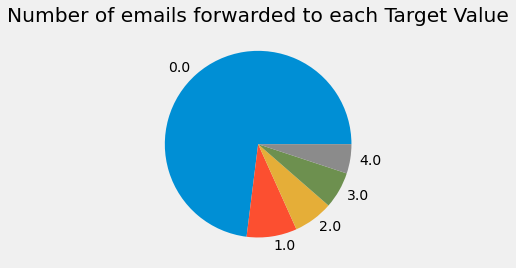

In [49]:
#Check the distribution of the target variable
df.value_counts('Target').plot(kind = 'pie')
plt.title('Number of emails forwarded to each Target Value');

Because the target distribution is not even, I will use stratified sampling when splitting the data into train and test.

In [50]:
df.head()

,To,Subject,og_body,Target
299386,"herman.manis@enron.com, lisa.bills@enron.com",ENA/Delta Documents Second Revision 4/3/01,ENA/Delta Documents Second Revision 4/3/01\n\n...,0.0
299392,john.schwartzenburg@enron.com,Re: REMINDER - CONFERENCE CALL - Wednesday - M...,Re: REMINDER - CONFERENCE CALL - Wednesday - M...,0.0
299393,stephen.thome@enron.com,Salmon Energy LLC Agreement,"Salmon Energy LLC Agreement\n\n\n\n""paulhastin...",0.0
299401,jeffrey.hodge@enron.com,"enovate, LLC","enovate, LLC\n\nGregg:\n\nHere is a very brief...",0.0
299418,pthompson@akllp.com,RE: Salmon Energy Turbine Agreement,"RE: Salmon Energy Turbine Agreement\n\nKay,\n\...",0.0


In [51]:
df = df.reset_index().drop(columns = ['index'])

Create Target and Features

In [52]:
df_target = df['Target']

In [53]:
df_features = df.drop(columns = 'Target')

In [54]:
df_target.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Target, dtype: float64

Split Train and Test

In [55]:
X_train_full, X_test, y_train_full, y_test = train_test_split(df_features, df_target,test_size=0.20, stratify=df_target,random_state=42)

In [56]:
y_train_full.value_counts()

0.0    885
1.0    105
2.0     83
3.0     77
4.0     62
Name: Target, dtype: int64

In [57]:
y_test.value_counts()

0.0    222
1.0     27
2.0     21
3.0     19
4.0     15
Name: Target, dtype: int64

Select only the email body to train the model

In [58]:
X_train_full['patterns'] = X_train_full['og_body']

In [59]:
X_test['patterns'] = X_test['og_body']

In [60]:
X_test['patterns'].to_csv("X_test_ee")

In [61]:
y_test.to_csv("y_test_ee")

In [62]:
X_train_full.head()

,To,Subject,og_body,patterns
117,"fred.mitro@enron.com, ben.jacoby@enron.com",Form of Purchase Option Notice,"Form of Purchase Option Notice\n\nKay,\nHere i...","Form of Purchase Option Notice\n\nKay,\nHere i..."
961,carlos.sole@enron.com,Closing Checklist,Closing Checklist\n\nHaving fun yet?\n--------...,Closing Checklist\n\nHaving fun yet?\n--------...
172,"ben.jacoby@enron.com, rebecca.walker@enron.com...",Exhibits to the CA Energy Development Agreements,Exhibits to the CA Energy Development Agreemen...,Exhibits to the CA Energy Development Agreemen...
217,stephen.plauche@enron.com,Agreement Documents,Agreement Documents\n\nHeather and Ozzie\nWe j...,Agreement Documents\n\nHeather and Ozzie\nWe j...
67,suzanne.adams@enron.com,EECC/ENA meeting - Pre-Meeting,EECC/ENA meeting - Pre-Meeting\n\nPlease let m...,EECC/ENA meeting - Pre-Meeting\n\nPlease let m...


In [63]:
y_train_full.values[1]

3.0

The following code was adapted from NeuralNine, 2020 where it was used to make a chatbot. I create the full word list based on the training set.

In [64]:

lemmatizer = WordNetLemmatizer()

patterns = X_train_full['patterns']
tags = y_train_full
words = []
classes = []
documents = []
ignoreLetters = ['?', '!', '.', ',','@','-',':',';','<','>']

#first each email is tokenized, and these are added to a word list. 
#Then a list is made of all the words in the all the emails. 
#a list is also made of unique target values
#the words are then lemmatized and we are left with a file with unique lemmatized words from all the emails
for i in range(len(patterns)):
    wordList = nltk.word_tokenize(patterns.values[i])
    words.extend(wordList)
    documents.append((wordList, tags.values[i]))
    if tags.values[i] not in classes:
        classes.append(tags.values[i])

words = [lemmatizer.lemmatize(word) for word in words if word not in ignoreLetters]
words = sorted(set(words))

classes = sorted(set(classes))

#Save full list of words and classes for use in the application
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [65]:
words

['#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'02",
 "'Amy",
 "'Brad",
 "'Brenda",
 "'Brian",
 "'Campbell",
 "'Cindy",
 "'Dale.Rasmussen",
 "'Dave",
 "'Hector",
 "'It",
 "'Jim.Gilbert",
 "'Julie",
 "'Kay.Mann",
 "'Kelly",
 "'Kerrie",
 "'Kim",
 "'Lawrence",
 "'Lori",
 "'Mom",
 "'Nancy",
 "'PARKER",
 "'PB",
 "'Phil",
 "'Rebecca",
 "'SUZANNE.ADAMS",
 "'Sandra",
 "'Scott",
 "'Scott.Healy",
 "'Sharon",
 "'Shoemaker",
 "'Stacey",
 "'Susan",
 "'Terri",
 "'The",
 "'Tishy",
 "'VAN",
 "'Valerie",
 "'We",
 "'While",
 "'aivancovich",
 "'ben.f.jacoby",
 "'ccampbell",
 "'chris.booth",
 "'christine",
 "'d",
 "'f_mitro",
 "'fred.mitro",
 "'green",
 "'gregorylang",
 "'heather",
 "'hello",
 "'iparker",
 "'kathleen.carnahan",
 "'kathleen.clark",
 "'kay.mann",
 "'kerry",
 "'lisa.obrien",
 "'ll",
 "'m",
 "'margueritekahn",
 "'michael.d.nanny",
 "'re",
 "'rusty.stevens",
 "'s",
 "'tconstan",
 "'ve",
 "'we",
 '(',
 ')',
 '*',
 '++++++CONFIDENTIALITY',
 '++1',
 '+44',
 '+7',
 '--',
 '-0400',
 '-0500',
 '-0600',
 '-1

In [66]:
#In this part we create a bag of words for each email and add them to the training set. 
#The result is an array where each row is an email encoded into a bag of words, with columns being each word and values either being 1 or 0
training = []
outputEmpty = [0] * len(classes)

for document in documents:
    bag = []
    wordPatterns = document[0]
    wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
    for word in words:
        bag.append(1) if word in wordPatterns else bag.append(0)
#Creates an output row for the target
    outputRow = list(outputEmpty)
    outputRow[classes.index(document[1])] = 1
    training.append(bag + outputRow)

random.shuffle(training)
training = np.array(training)

trainX = training[:, :len(words)]
trainY = training[:, len(words):]

To test the model, I created a test set that fits into the same array created to train the models (see above). In other words: each message in the test set is turned into a bag of words based on the words present in the training set.
- The test set created below will be used to assess simpler classification models (decision tree and K-nearest Neighbors)
- To test the Neural Network model created by NeuralNine, 2020 I will use the predict_class function that they created for the chat bot.

In [67]:
test = []
outputEmpty = [0] * len(classes)
patterns_test = X_test['patterns']
tags = y_test

documents_test = []
ignoreLetters = ['?', '!', '.', ',','@','-',':',';','<','>']

for i in range(len(patterns_test)):
    wordList = nltk.word_tokenize(patterns_test.values[i])
    
    documents_test.append((wordList, tags.values[i]))

for document in documents_test:
    bag = []
    wordPatterns = document[0]
    wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
    for word in words:
        bag.append(1) if word in wordPatterns else bag.append(0)
#Creates an output row for the target
    outputRow = list(outputEmpty)
    outputRow[classes.index(document[1])] = 1
    test.append(bag + outputRow)

random.shuffle(test)
test = np.array(test)

testX = test[:, :len(words)]
testY = test[:, len(words):]

In [68]:
trainX.shape

(1212, 10303)

In [69]:
trainY.shape

(1212, 5)

In [70]:
testX.shape

(304, 10303)

In [71]:
testY.shape

(304, 5)

In [72]:
#need to delete the model before retraining
#del model 

The model architecture below is based on the model for the chatbot retrieved from NeuralNine, 2020:

In [73]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape=(len(trainX[0]),), activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(trainY[0]), activation='softmax'))

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(trainX, trainY, epochs=200, batch_size=5, verbose=1)
model.save('email_model.h5')
print('Done')

Epoch 1/200
243/243 [==============================] - 6s 19ms/step - loss: 0.9553 - accuracy: 0.7236
Epoch 2/200
243/243 [==============================] - 5s 20ms/step - loss: 0.6812 - accuracy: 0.7599
Epoch 3/200
243/243 [==============================] - 4s 18ms/step - loss: 0.4794 - accuracy: 0.8391
Epoch 4/200
243/243 [==============================] - 4s 18ms/step - loss: 0.3896 - accuracy: 0.8787
Epoch 5/200
243/243 [==============================] - 4s 18ms/step - loss: 0.3177 - accuracy: 0.9018
Epoch 6/200
243/243 [==============================] - 5s 19ms/step - loss: 0.2811 - accuracy: 0.9208
Epoch 7/200
243/243 [==============================] - 4s 17ms/step - loss: 0.2040 - accuracy: 0.9348
Epoch 8/200
243/243 [==============================] - 4s 16ms/step - loss: 0.1968 - accuracy: 0.9455
Epoch 9/200
243/243 [==============================] - 5s 19ms/step - loss: 0.2106 - accuracy: 0.9414
Epoch 10/200
243/243 [==============================] - 5s 21ms/step - loss: 0.167

243/243 [==============================] - 5s 19ms/step - loss: 0.0596 - accuracy: 0.9744
Epoch 81/200
243/243 [==============================] - 5s 20ms/step - loss: 0.0640 - accuracy: 0.9703
Epoch 82/200
243/243 [==============================] - 4s 17ms/step - loss: 0.0617 - accuracy: 0.9752
Epoch 83/200
243/243 [==============================] - 4s 18ms/step - loss: 0.0663 - accuracy: 0.9711
Epoch 84/200
243/243 [==============================] - 5s 20ms/step - loss: 0.0743 - accuracy: 0.9662
Epoch 85/200
243/243 [==============================] - 4s 18ms/step - loss: 0.0622 - accuracy: 0.9752
Epoch 86/200
243/243 [==============================] - 4s 16ms/step - loss: 0.0866 - accuracy: 0.9744
Epoch 87/200
243/243 [==============================] - 4s 17ms/step - loss: 0.0653 - accuracy: 0.9711
Epoch 88/200
243/243 [==============================] - 4s 17ms/step - loss: 0.0583 - accuracy: 0.9711
Epoch 89/200
243/243 [==============================] - 5s 19ms/step - loss: 0.0503 - 

243/243 [==============================] - 4s 15ms/step - loss: 0.0504 - accuracy: 0.9736
Epoch 160/200
243/243 [==============================] - 4s 15ms/step - loss: 0.0689 - accuracy: 0.9711
Epoch 161/200
243/243 [==============================] - 4s 15ms/step - loss: 0.0520 - accuracy: 0.9777
Epoch 162/200
243/243 [==============================] - 4s 15ms/step - loss: 0.0487 - accuracy: 0.9761
Epoch 163/200
243/243 [==============================] - 4s 16ms/step - loss: 0.0694 - accuracy: 0.9711
Epoch 164/200
243/243 [==============================] - 4s 18ms/step - loss: 0.0547 - accuracy: 0.9769
Epoch 165/200
243/243 [==============================] - 4s 16ms/step - loss: 0.0690 - accuracy: 0.9719
Epoch 166/200
243/243 [==============================] - 4s 16ms/step - loss: 0.0647 - accuracy: 0.9728
Epoch 167/200
243/243 [==============================] - 4s 15ms/step - loss: 0.0561 - accuracy: 0.9769
Epoch 168/200
243/243 [==============================] - 4s 15ms/step - loss: 

After examining the Accuracy and Loss from the model above I decided by reduce the Epoch's to 35, as this seems to be where the accuracy peaked.

In [74]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape=(len(trainX[0]),), activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(len(trainY[0]), activation='softmax'))

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.fit(trainX, trainY, epochs=35, batch_size=5, verbose=1)
model.save('email_model_2.h5')

print('Done')

Epoch 1/35
243/243 [==============================] - 6s 20ms/step - loss: 0.9717 - accuracy: 0.7203
Epoch 2/35
243/243 [==============================] - 5s 20ms/step - loss: 0.6747 - accuracy: 0.7789
Epoch 3/35
243/243 [==============================] - 4s 18ms/step - loss: 0.5586 - accuracy: 0.8366
Epoch 4/35
243/243 [==============================] - 4s 18ms/step - loss: 0.4697 - accuracy: 0.8366
Epoch 5/35
243/243 [==============================] - 4s 16ms/step - loss: 0.3900 - accuracy: 0.8828
Epoch 6/35
243/243 [==============================] - 4s 18ms/step - loss: 0.3474 - accuracy: 0.9018
Epoch 7/35
243/243 [==============================] - 4s 17ms/step - loss: 0.3511 - accuracy: 0.8960
Epoch 8/35
243/243 [==============================] - 4s 17ms/step - loss: 0.2708 - accuracy: 0.9167
Epoch 9/35
243/243 [==============================] - 4s 17ms/step - loss: 0.2486 - accuracy: 0.9191
Epoch 10/35
243/243 [==============================] - 5s 22ms/step - loss: 0.2517 - accura

To test the model, I used some of the functions defined by NeuralNine, 2020 to predict the class of each message in the test set. Using these functions, I could feed each email message in as text and create a dataframe with the predicted class and probability. I then compared the results to the original target.

In [75]:
#Functions taken from NeuralNine, 2020.
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word) for word in sentence_words]
    return sentence_words

def bag_of_words(sentence):
    sentence_words = clean_up_sentence(sentence)
    bag = [0]*len(words)
    for w in sentence_words:
        for i, word in enumerate(words):
            if word == w:
                bag[i] = 1
    return np.array(bag)

In [76]:
#Function taken from NeuralNine, 2020.
#'intent' is the equivalent of the predicted class.
def predict_class(sentence):
    bow = bag_of_words(sentence)
    res = model.predict(np.array([bow]))[0]
    ERROR_THRESHOLD = 0.25
    result = [[i,r] for i, r in enumerate(res) if r> ERROR_THRESHOLD]
    
    result.sort(key=lambda x:x[1], reverse = True)
    return_list = []
    return_list.append({'intent':classes[result[0][0]],'probability':str(result[0][1])})
    return return_list

In [77]:
#Create a list of predictions and probabilities for each message in the test set
pred_list = []
for i in range(len((list(X_test['patterns'])))):
    pred_list.extend(predict_class(list(X_test['patterns'])[i]))

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 20ms/step


In [78]:
#turn predictions and probabilities into a dataframe
nn_pred_prob_df = pd.DataFrame(pred_list)

In [79]:
nn_pred_prob_df.head(2)

,intent,probability
0,0.0,0.9999708
1,3.0,0.9962412


In [80]:
len(nn_pred_prob_df)

304

In [81]:
len(y_test)

304

In [82]:
#To compare the two series y_test and predicted values, I had to drop the original index values in y_test
y_test = y_test.reset_index().drop(columns = ['index'])

In [83]:
#Make a dataframe with the predictions, probabilities and actual target values for the test set
y_v_y_hat = pd.concat([y_test,nn_pred_prob_df], axis=1)

In [84]:
y_v_y_hat.head()

,Target,intent,probability
0,0.0,0.0,0.9999708
1,3.0,3.0,0.9962412
2,4.0,4.0,1.0
3,0.0,0.0,0.6341276
4,0.0,0.0,1.0


In [85]:
#Compute the accuracy. 'Target' is y actual, 'intent' is predicted values
sum(y_v_y_hat['Target'] == y_v_y_hat['intent'])/len(y_v_y_hat)

0.9671052631578947

In [86]:
#Save this dataframe, because it will be used to determine the probability threshold in the next notebook
y_v_y_hat.to_csv("model_predictions_test.csv")

<h2> Compare Performance with Simpler Models </h2> 

The accuracy of the chatbot model on the the test set was pretty good but it was quite complicated, so I wanted to check to see if I could get similar accuracy from some simpler algorithms

In [87]:
#trainX and trainY are the same as were used in the Neural Network Model
#testX and testY are the messages and targets from the training set that are turned into arrays of the same shape as trainX and trainY
dt = DecisionTreeClassifier()
dt.fit(trainX, trainY)
dt_pred = dt.predict(testX)
accuracy_score(testY, dt_pred)

0.9605263157894737

In [88]:
knn = KNeighborsClassifier()
knn.fit(trainX,trainY)
knn_pred = knn.predict(testX)
accuracy_score(testY, knn_pred)

0.8980263157894737

The simple Decision Tree model has pretty good performance compared with the neural network model (96% accuracy for dt compared with 97% accuracy for NN)
- For my portfolio I would like to do the following:
    - Use k-fold cross validation to see the stability of the decision tree model
    - See if I can tune the hyperparameters of the decision tree model to reach or exceed the performance of the neural network model.
    
Even though the accuracy of the neural network model is only slightly higher than the simple decision tree, the benefit is that it gives a probability assigned with each prediction. This is quite important for my problem of auto-forwarding emails because it means I can build my auto-forwarding function to only foward emails with a very high probability of belonging to a certain class.